In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw


Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw
Processing...


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [4]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [5]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [6]:
X_train = X_train.float()
X_test = X_test.float()

In [7]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

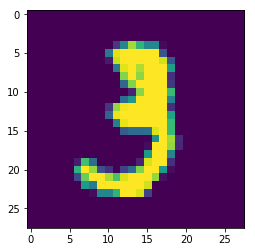

tensor(3)


In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[10, :, :])
plt.show()
print(y_train[10])

In [10]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [11]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [12]:
torch.cuda.is_available()

False

In [14]:
# !nvidia-smi

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())

In [17]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [18]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9102)
tensor(0.9197)
tensor(0.9221)
tensor(0.9220)
tensor(0.9256)
tensor(0.9261)
tensor(0.9222)
tensor(0.9329)
tensor(0.9216)
tensor(0.9307)


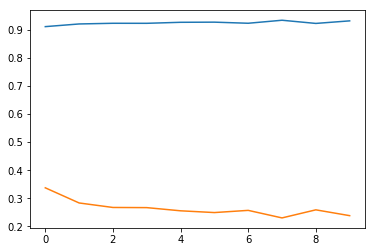

In [19]:
plt.plot(test_accuracy_history)
plt.plot(test_loss_history);